# Importowanie bibliotek


In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, sin, cos, sqrt, asin 
from shapely.geometry import LineString

# Wczytanie danych

In [2]:
df = pd.read_csv("bird_migration_data.csv", sep=",")
df.head()
connection = sqlite3.connect(":memory:")
df.to_sql("migrations", connection, index=False, if_exists="replace")

10000

In [3]:
schema_df = pd.read_sql_query("PRAGMA table_info(migrations);", connection)
print(schema_df)

    cid                     name     type  notnull dflt_value  pk
0     0                  Bird_ID     TEXT        0       None   0
1     1                  Species     TEXT        0       None   0
2     2                   Region     TEXT        0       None   0
3     3                  Habitat     TEXT        0       None   0
4     4        Weather_Condition     TEXT        0       None   0
5     5         Migration_Reason     TEXT        0       None   0
6     6           Start_Latitude     REAL        0       None   0
7     7          Start_Longitude     REAL        0       None   0
8     8             End_Latitude     REAL        0       None   0
9     9            End_Longitude     REAL        0       None   0
10   10       Flight_Distance_km     REAL        0       None   0
11   11    Flight_Duration_hours     REAL        0       None   0
12   12       Average_Speed_kmph     REAL        0       None   0
13   13           Max_Altitude_m  INTEGER        0       None   0
14   14   

# Funkcja Harvesine 


In [4]:
def haversine(lat1, lon1, lat2, lon2):
    #latitude1,longitude1
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 #Średni promień Ziemii
    return c * r

# Wyznaczenie korelacji zmiennych

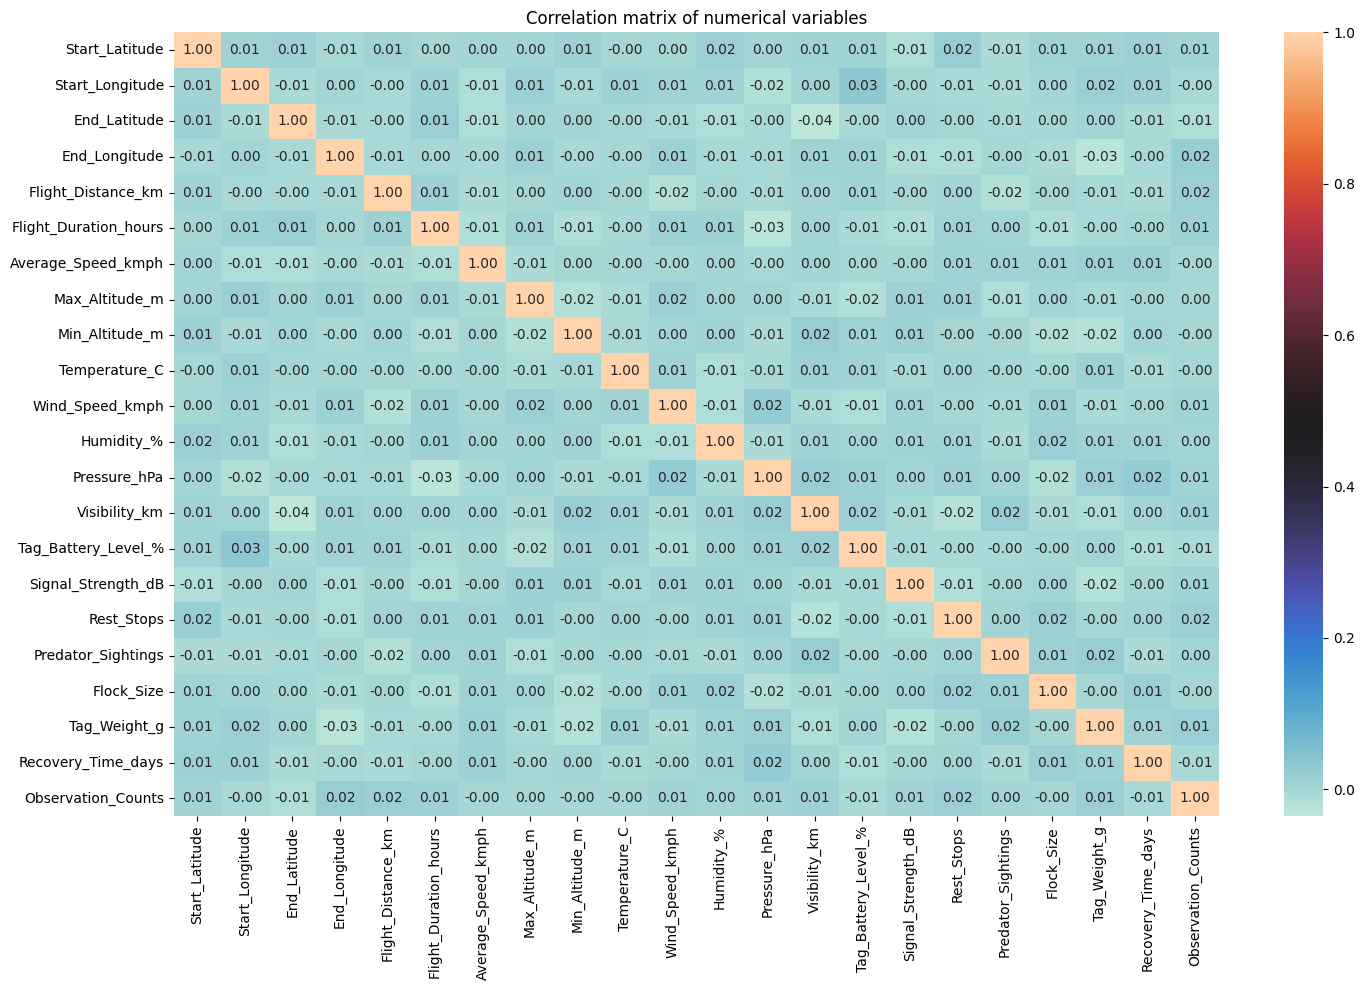

In [5]:
df = pd.read_sql_query("SELECT * FROM migrations;", connection)

# Tylko kolumny numeryczne
num_cols = df.select_dtypes(include=["float64", "int64"])
corr = num_cols.corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True, cmap='icefire', fmt=".2f")
plt.title("Correlation matrix of numerical variables")
plt.tight_layout()
plt.show()

# Rozkład odległości migracji



Migration Distance Statistics:
count    10000.000000
mean      9959.027012
std       4751.284834
min        106.361207
25%       6187.433993
50%       9901.357501
75%      13736.965571
max      19970.820160
Name: Distance_km, dtype: float64


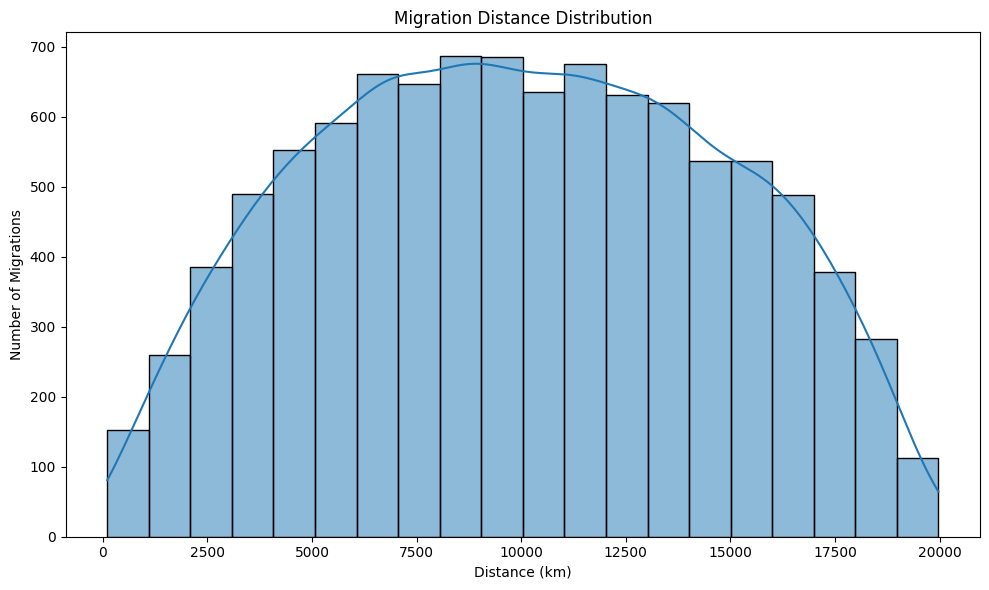

In [6]:
df = pd.read_csv("bird_migration_data.csv")
df.columns = df.columns.str.strip()

# Obliczenie dystansu
df["Distance_km"] = df.apply(lambda row: haversine(row["Start_Latitude"], row["Start_Longitude"],row["End_Latitude"], row["End_Longitude"]), axis=1)

# Statystyki 
print("\nMigration Distance Statistics:")
print(df["Distance_km"].describe())

# Wykres
plt.figure(figsize=(10, 6))
sns.histplot(df["Distance_km"], bins=20, kde=True)
plt.title("Migration Distance Distribution")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Migrations")
plt.tight_layout()
plt.show()



# Zapytania w języku SQL oraz wizualizacja danych


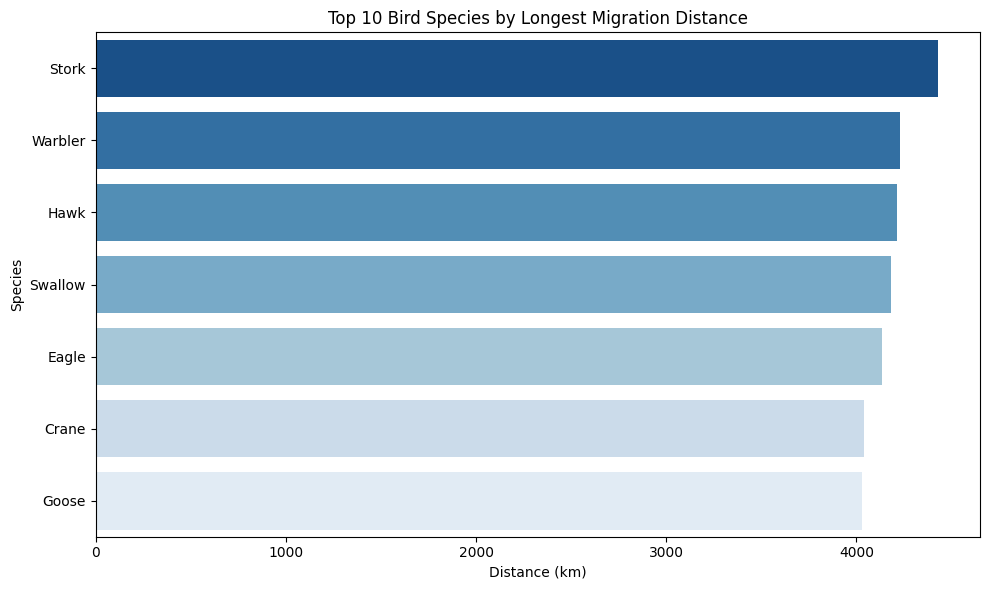

In [7]:
query1 = """
SELECT Species, MAX(Flight_Distance_km) AS Max_Distance
FROM migrations
GROUP BY Species
ORDER BY Max_Distance DESC
LIMIT 10;
"""
longest_distance = pd.read_sql(query1, connection)

# Odwrócenie koloru seaborn
colors = sns.color_palette("Blues", n_colors=len(longest_distance))[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(data=longest_distance, x="Max_Distance", y="Species",  hue="Species", palette=colors, legend=False)
plt.title("Top 10 Bird Species by Longest Migration Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Species")
plt.tight_layout()
plt.show()


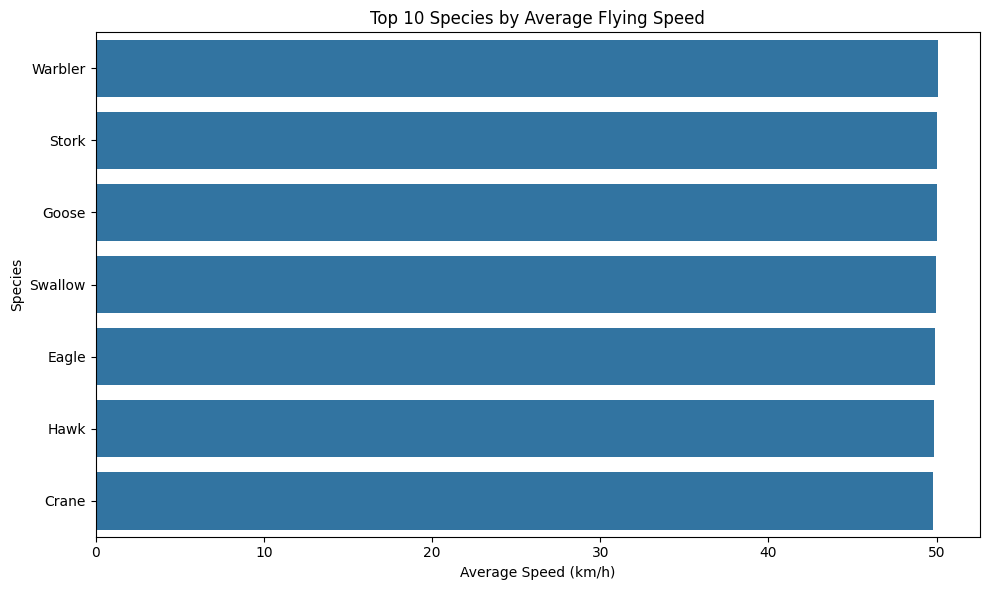

In [8]:
query2 = """
SELECT Species, AVG(Average_Speed_kmph) AS avg_speed
FROM migrations
GROUP BY Species
ORDER BY avg_speed DESC
LIMIT 10;
"""
df = pd.read_sql_query(query2, connection)

# Wykres
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="avg_speed", y="Species", color="#1f77b4")
plt.title("Top 10 Species by Average Flying Speed")
plt.xlabel("Average Speed (km/h)")
plt.ylabel("Species")
plt.tight_layout()
plt.show()


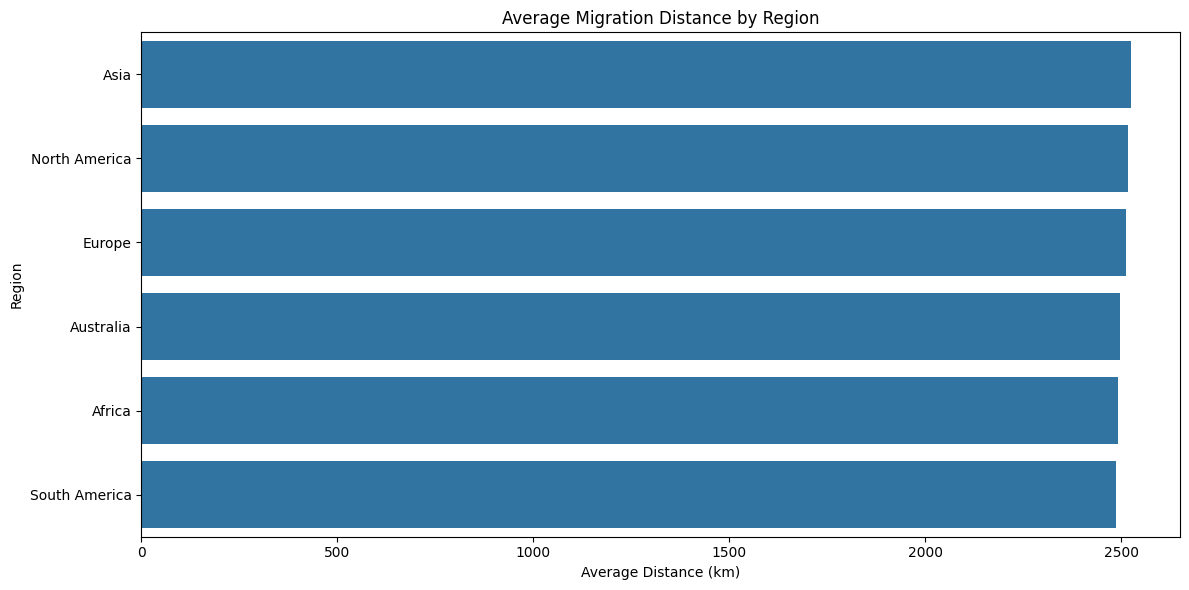

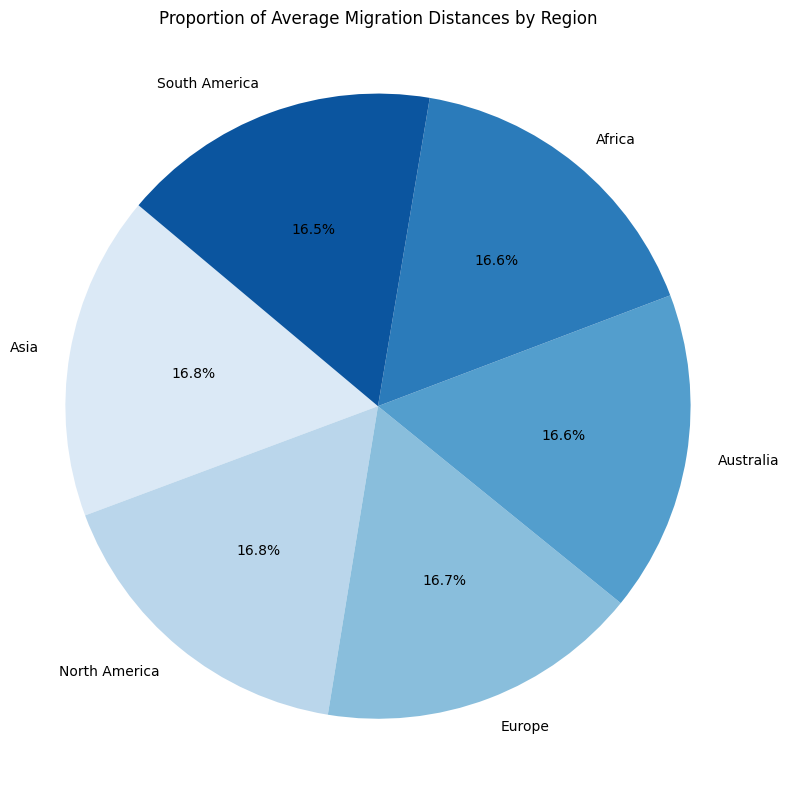

In [9]:
query3 = """
SELECT Region, AVG(Flight_Distance_km) AS Avg_Distance
FROM migrations
GROUP BY Region
ORDER BY Avg_Distance DESC;
"""

avg_distance_by_region = pd.read_sql(query3, connection)

# Wykres 1
plt.figure(figsize=(12, 6))
sns.barplot(data=avg_distance_by_region, x="Avg_Distance", y="Region", color="#1f77b4")
plt.title("Average Migration Distance by Region")
plt.xlabel("Average Distance (km)")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

# Proporcje
avg_distance_by_region["Proportion"] = avg_distance_by_region["Avg_Distance"] / avg_distance_by_region["Avg_Distance"].sum()

# Zdefiniowanie palety kolorów, potem wykorzystuje ją ponownie w projekcie
colors = sns.color_palette("Blues", len(avg_distance_by_region))

# Wykres 2
plt.figure(figsize=(8, 8))
plt.pie(avg_distance_by_region["Proportion"], labels=avg_distance_by_region["Region"],autopct="%1.1f%%", startangle=140, colors=colors)
plt.title("Proportion of Average Migration Distances by Region")
plt.axis("equal")
plt.tight_layout()
plt.show()



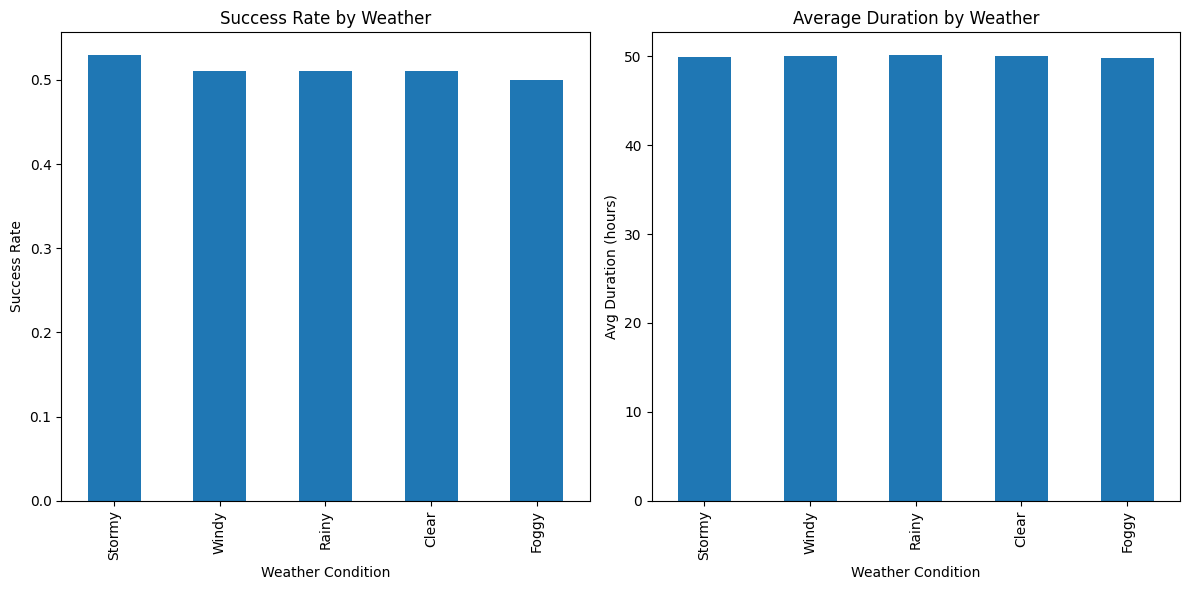

In [10]:
query4 = """
SELECT Weather_Condition,
       ROUND(AVG(CASE WHEN Migration_Success = 'Successful' THEN 1 ELSE 0 END), 2) AS Success_Rate,
       ROUND(AVG(Flight_Duration_hours), 1) AS Avg_Duration
FROM migrations
GROUP BY Weather_Condition
ORDER BY Success_Rate DESC;
"""

weather_effect = pd.read_sql(query4, connection)

plt.figure(figsize=(12, 6))

# Wykres 1
plt.subplot(1, 2, 1)
weather_effect.plot(kind="bar", x="Weather_Condition", y="Success_Rate", title="Success Rate by Weather", ax=plt.gca(), color="#1f77b4", legend=False)
plt.xlabel("Weather Condition")
plt.ylabel("Success Rate")

# Wykres 2

plt.subplot(1, 2, 2)
weather_effect.plot(kind="bar", x="Weather_Condition", y="Avg_Duration", title="Average Duration by Weather", ax=plt.gca(),  color="#1f77b4", legend=False)
plt.xlabel("Weather Condition")
plt.ylabel("Avg Duration (hours)")
plt.tight_layout()
plt.show()


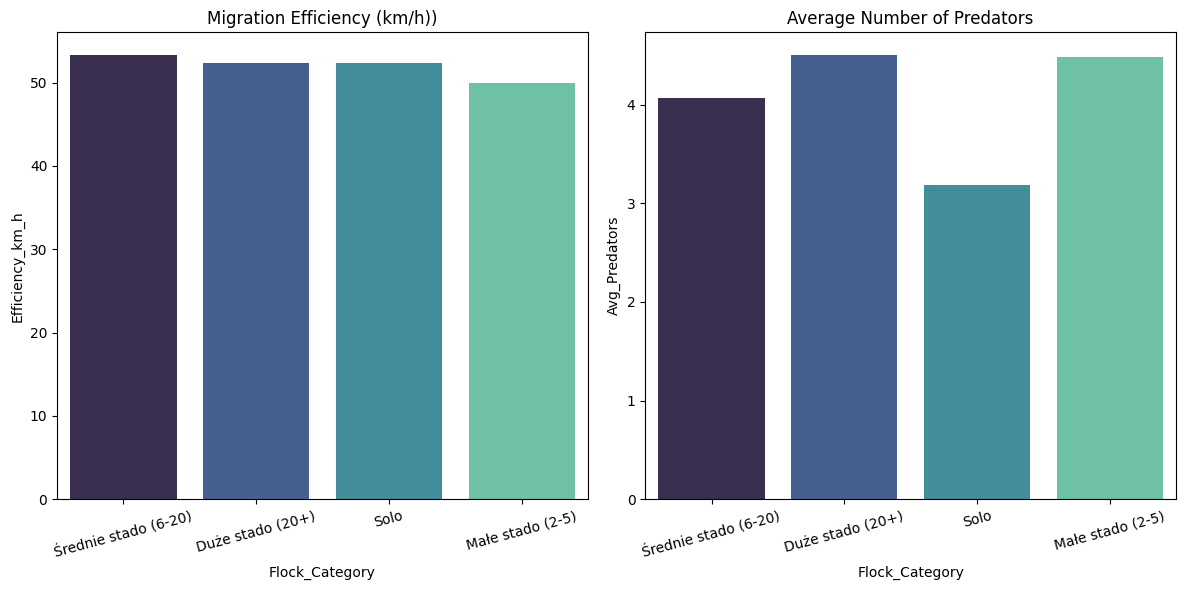

In [11]:
query5 = """
SELECT 
    CASE 
        WHEN Flock_size = 1 THEN 'Solo'
        WHEN Flock_size BETWEEN 2 AND 5 THEN 'Małe stado (2-5)'
        WHEN Flock_size BETWEEN 6 AND 20 THEN 'Średnie stado (6-20)'
        ELSE 'Duże stado (20+)'
    END AS Flock_Category,
    AVG(Flight_Distance_km/Flight_Duration_hours) AS Efficiency_km_h,
    AVG(Predator_Sightings) AS Avg_Predators
FROM migrations
WHERE Flock_size IS NOT NULL
GROUP BY Flock_Category
ORDER BY Efficiency_km_h DESC;
"""

flock_efficiency = pd.read_sql(query5, connection)

# Wiykres
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=flock_efficiency,x="Flock_Category", hue="Flock_Category", y="Efficiency_km_h", palette="mako", legend=False)
plt.title("Migration Efficiency (km/h))")
plt.xticks(rotation=15)
plt.subplot(1, 2, 2)
sns.barplot(data=flock_efficiency,x="Flock_Category", hue="Flock_Category", y="Avg_Predators", palette="mako", legend=False)
plt.title("Average Number of Predators")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

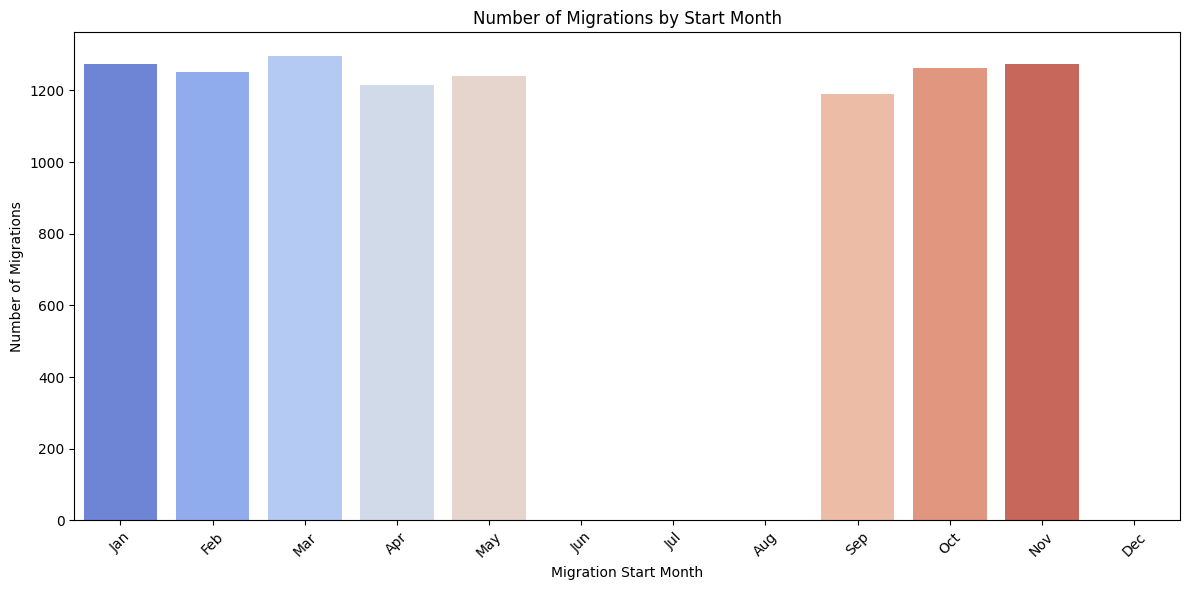

In [12]:
query6 = """  
SELECT Migration_Start_Month AS month, COUNT(*) AS count  
FROM migrations  
GROUP BY month;
"""  
df = pd.read_sql_query(query6, connection)  

# Lista miesięcy
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Filtrowanie i sortowanie
df = df[df["month"].isin(month_order)].sort_values(by="month", key=lambda x: pd.Categorical(x, categories=month_order, ordered=True))

# Wykres
plt.figure(figsize=(12, 6))  
sns.barplot(data=df, x="month", y="count", hue="month", 
            palette="coolwarm", legend=False, order=month_order)  

plt.title("Number of Migrations by Start Month")  
plt.xlabel("Migration Start Month")
plt.ylabel("Number of Migrations")
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()


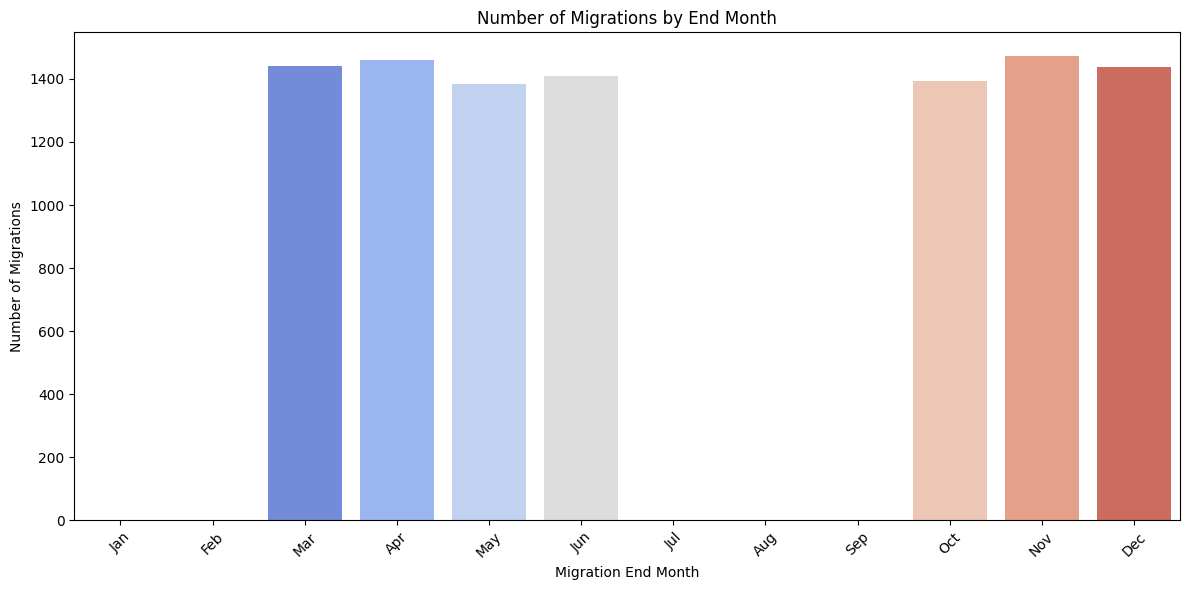

In [13]:
query7 = """  
SELECT Migration_End_Month AS month, COUNT(*) AS count  
FROM migrations  
WHERE Migration_End_Month IS NOT NULL  
GROUP BY month;  
"""  
df = pd.read_sql_query(query7, connection)  

# Lista miesięcy
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Filtrowanie i sortowanie
df = df[df["month"].isin(month_order)].sort_values(
    by="month", 
    key=lambda x: pd.Categorical(x, categories=month_order, ordered=True)
)

# Wykres
plt.figure(figsize=(12, 6))  
sns.barplot(data=df, x="month", y="count", hue="month",  palette="coolwarm", legend=False, order=month_order)  

plt.title("Number of Migrations by End Month")  
plt.xlabel("Migration End Month")
plt.ylabel("Number of Migrations")
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()
